In [1]:
import dit
import os
import json
import numpy as np
import pandas as pd

from collections import Counter
from src.data_loader import Shifted_Data_Loader
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import model_from_json

from statsmodels.nonparametric.smoothers_lowess import lowess
from dit import ScalarDistribution

Using TensorFlow backend.


See Notebook '05-Corrupted-labels' for details on training

In [2]:
np.random.seed(7)

In [3]:
180000 / 60000.0

3.0

In [4]:
DL = Shifted_Data_Loader('fashion_mnist',
                    rotation=None,
                    translation=0.9,flatten=False,num_train=60000,
                   )


input_shape:  (56, 56, 1)
dataset:  fashion_mnist
scale:  2
tx_max:  0.9
rot_max:  None
bg_noise: None
loading fashion_mnist...
sx_train:  (60000, 56, 56, 1)
making training data...
making testing data...


In [5]:
corruption_fractions = np.round(np.linspace(0,1,11),decimals=1)
idxs_corr = [np.random.choice(np.arange(60000),int(frac*60000),replace=False) for frac in corruption_fractions]
y_tr = DL.y_train.copy()

In [6]:
idxs_corr[3]

array([41654, 57046, 46308, ..., 46214, 58271, 27242])

In [7]:
n = 5

list(filter(lambda v: v!=n,np.arange(10)) )


[0, 1, 2, 3, 4, 6, 7, 8, 9]

In [8]:
[np.arange(10)]*10

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]

In [9]:
opt = [list(filter(lambda x: x!=n,np.arange(10).tolist())) for n in np.arange(10)]

In [10]:
np.random.choice(opt[0])

6

In [11]:
# y_corr_tr = []
# for idxs in idxs_corr[1:]:
#     y_corr = y_tr.copy()
#     curr_labels = DL.y_train[idxs]
#     new_labels = [np.random.choice(opt[l]) for l in curr_labels]
#     y_corr[idxs] = new_labels
#     y_corr_tr.append(y_corr)

In [12]:
# [len(y) for y in y_corr_tr]

In [13]:
# for y,frac in zip(y_corr_tr,corruption_fractions[1:]):
#     np.save('../data/fashion_mnist_corrupted_labels/y_train_{}'.format(np.round(frac,1)),y)

In [14]:
# for idxs,frac in zip(idxs_corr[1:],corruption_fractions[1:]):
#     np.save('../data/fashion_mnist_corrupted_labels/corrupted_idxs_{}'.format(np.round(frac,1)),idxs)

In [15]:
y_tr_idxs = [np.load('../data/fashion_mnist_corrupted_labels/corrupted_idxs_{}.npy'.format(str(pct))) for pct in corruption_fractions[1:]]
y_tr_corr = [np.load('../data/fashion_mnist_corrupted_labels/y_train_{}.npy'.format(str(pct))) for pct in corruption_fractions[1:]]
# y_corrupted_oh = to_categorical(y_tr_corr,num_classes=10)

In [16]:
corr_idxs_tr = y_tr_idxs[2]
y_trc = y_tr_corr[2]

In [17]:
DL.delta_train.shape

(60000, 3)

In [18]:
DL.gen_corrupted_shift_image(corr_idxs_tr,y_trc)

generating train_sx_corr...


18000it [00:00, 23239.19it/s]


In [19]:
DL.y_train[corr_idxs_tr][:5]

array([5, 7, 6, 3, 1], dtype=uint8)

In [20]:
y_trc[corr_idxs_tr][:5]

array([2, 6, 4, 5, 2], dtype=uint8)

In [21]:
corr_ims = DL.sx_train[corr_idxs_tr[:5]]
DL.delta_train[corr_idxs_tr[:5]]-14

array([[-10.,  -2., -14.],
       [  9., -11., -14.],
       [  2.,  -8., -14.],
       [ -1.,  -6., -14.],
       [  7.,  -7., -14.]])

In [22]:
def corr_im(idx):
    true_label = DL.y_train[idx]
    corr_label = y_trc[idx]
    print('{} -> {}'.format(true_label,corr_label))
    new_image_idx = np.random.choice(np.where(DL.y_train == corr_label)[0],replace=False)
    print(new_image_idx)
    new_X = DL.x_train[new_image_idx]
    (dx,dy,dr) = DL.delta_train[idx]
    new_shifted_image = DL.regen_shift_image(new_X,int(dx),int(dy))
    return new_shifted_image

In [23]:
new_ims = [corr_im(idx) for idx in corr_idxs_tr[:5]]

5 -> 2
12936
7 -> 6
8806
6 -> 4
43791
3 -> 5
42279
1 -> 2
21516


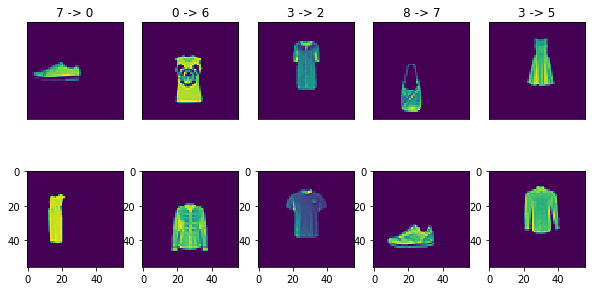

In [24]:
fig,axs = plt.subplots(2,5,figsize=(10,5))
for i,idx in zip(np.arange(5),np.random.choice(corr_idxs_tr,size=5)):
    ax = axs[0,i]
    axs[0,i].imshow(DL.sx_train[idx].reshape(56,56))
    axs[1,i].imshow(DL.sx_train_corrupted[idx].reshape(56,56))
    ax.set_title('{} -> {}'.format(DL.y_train[idx],y_trc[idx]))
    ax.set_yticks([])
    ax.set_xticks([])

In [26]:
def lowess_smooth(dat,time):
    filtered = lowess(dat, time, is_sorted=True,frac=0.01,it=1)
    return filtered

def sma(y,win_size):
    weights = np.repeat(1.0, win_size) / win_size
    yMA = np.convolve(y, weights, 'same')
    return yMA

def load_config(run_dir,filename='config.json'):
    path = os.path.join(run_dir,filename)
    if os.path.exists(path):
        with open(path,'r') as config_json:
            conf = json.load(config_json)
        return conf

def load_model_spec(run_dir,filename='model.json'):
    path = os.path.join(run_dir,filename)

    if os.path.exists(path):
        with open(path,'r') as model_json:
            mod_spec = json.load(model_json)
            
        return mod_spec

def load_train_history(run_dir,conf,filename='train_history.parquet'):
    path = os.path.join(run_dir,filename)
    dirname,fname = os.path.split(path)
#     lab_corruption = np.round(float(dirname.split('/')[-1].split('_')[-1]),decimals=1)
#     arch = dirname.split('/')[-2]
    if conf is None:
        return None
    elif conf['recon'] == 0:
        arch = 'no_recon'
    else:
        arch = 'recon'

    if os.path.exists(path):
        hist = pd.read_parquet(path)
        hist['architecture'] = arch
        hist['label_corruption'] = conf['label_corruption']
        hist['ecc_max'] = conf['ecc_max']
        hist['epoch'] = list(hist.index.values)
#         hist['val_loss'] = sma(hist['val_loss'].values,win_size=3)
#         hist['loss'] = sma(hist['loss'].values,win_size=3)
        hist['val_dL'] = np.gradient(hist['val_loss'])
        hist['test_err'] = 1-hist['val_class_acc']
        hist['train_err'] = 1-hist['class_acc']
        hist['recon_gen_err'] = hist.G_loss - hist.val_G_loss
        hist['gen_err'] = hist.loss - hist.val_loss
        hist['class_gen_err'] = hist.class_loss - hist.val_class_loss
        hist['class_gen_acc'] = hist.class_acc - hist.val_class_acc

        return hist

def load_performance(run_dir, conf, th=None, filename='performance.json'):
    path = os.path.join(run_dir,filename)
#     dirname,fname = os.path.split(path)
#     arch = dirname.split('/')[-2]
    if conf is None:
        return None
    elif conf['recon'] == 0:
        arch = 'no_recon'
    else:
        arch = 'recon'

    if os.path.exists(path):
        with open(path, 'rb') as json:
            
            perf = pd.read_json(json)
            perf['architecture'] = arch

            perf['test_err'] = 1-perf['test_acc']
        if th is not None:
            perf['test_acc_max'] = th['val_class_acc'].values.max()
            perf['tt_overfit'] = np.argmax(th['val_class_acc'].values)
            tt_mem_bin_vec = (th['class_acc'].values<= 1-conf['label_corruption']).astype(int)
            perf['tt_memorization'] = tt_mem_bin_vec.sum()
            perf['test_err_min'] = 1-perf['test_acc_max']
            perf['test_acc_auc'] = np.trapz(th['val_class_acc'])
            perf['test_loss_auc'] = np.trapz(th['val_class_loss'])
            perf['train_loss_auc'] = np.trapz(th['class_loss'])
        return perf

In [27]:
exp_root = '/home/elijahc/projects/vae/models/2019-04-01'
runs = []
for branches in os.listdir(exp_root):
    for leaf in os.listdir(os.path.join(exp_root,branches)):
        runs.append(os.path.join(exp_root,branches,leaf))
# recon_ecc_root = os.path.join(exp_root,'recon_and_ecc')
# recon_runs = [os.path.join(recon_root,d) for d in os.listdir(recon_root)]
# recon_runs.extend([os.path.join(recon_ecc_root,d) for d in os.listdir(recon_ecc_root)])
runs = list(filter(lambda x: 'ipynb_checkpoints' not in x,runs))
configs = [load_config(rd) for rd in runs]
train_historys = [load_train_history(rd,conf) for rd,conf in zip(runs,configs)]
perf = [load_performance(rd,conf,th) for rd,conf,th in zip(runs,configs,train_historys)]
model_specs = [load_model_spec(rd) for rd in runs]
# resp_dists = [load_resp_dist(rd) for rd in runs]
# resp_entropy = [dit.shannon.entropy(d) for d in resp_dists]


# no_recon_root = os.path.join(exp_root,'no-recon')
# no_recon_runs = [os.path.join(no_recon_root,d) for d in os.listdir(no_recon_root)]
# no_recon_configs = 
# no_recon_train_historys = [load_train_history(rd,'no_recon') for rd in no_recon_runs]
# no_recon_perf = [load_performance(rd,'no_recon') for rd in no_recon_runs]

In [28]:
configs_df = pd.DataFrame.from_records(configs)

In [29]:
len(model_specs)

24

In [30]:
len(configs_df.model_name)

24

In [31]:
configs_df.to_csv('../models/experiments/label_corruption_large_z/all_configs.csv')

In [32]:
hist_df = pd.concat(train_historys)

In [33]:
hist_df.to_csv('../models/experiments/label_corruption_large_z/train_history_all.csv')

In [34]:
perf_df = pd.concat(perf)

In [35]:
perf_df.to_csv('../models/experiments/label_corruption_large_z/performance_summary_all.csv')

In [36]:
def train_plot(metric,filts={'ecc_max':0.0,'architecture':'no_recon'},pop_out_legend=True,legend='full'):
    pd_query = []
    for k in filts.keys():
        if isinstance(filts[k],str):
            qs = "{} == '{}'".format(k,filts[k])
        else:
            qs = "{} == {}".format(k,filts[k])
        
        pd_query.append(qs)
        
    if legend is not None and pop_out_legend:
        fig_size = (8,5)
    else:
        fig_size = (5,5)
    
    fig,ax = plt.subplots(1,1,figsize=fig_size)
    
    sns.lineplot(x='epoch',y=metric,hue='label_corruption',data=hist_df.query(' & '.join(pd_query)),legend=legend,ax=ax)
    
    if legend is not None and pop_out_legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    for c,chance in zip(sns.cubehelix_palette(6,reverse=True,start=1),[0.1,0.2,0.4,0.6,0.8]): 
            ax.axhline(y=chance,ls='dashed',color=c,xmin=0.0,xmax=0.5)
    
    plt.tight_layout()
    return fig

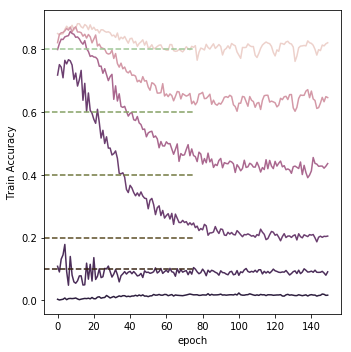

In [37]:
fig = train_plot('val_class_acc',legend=None)
plt.ylabel('Train Accuracy');

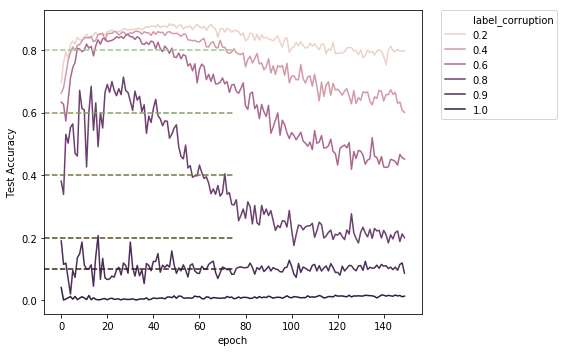

In [38]:
fig = train_plot('val_class_acc',legend='full',pop_out_legend=True,
          filts={
              'ecc_max':0.0,
              'architecture':'recon'
          },
          )
plt.ylabel('Test Accuracy');
# plt.

In [39]:
def recon_ecc_grid(metric='class_acc',sharey=True,sharex=True,subplot_kw=None,pop_out_legend=False):
    archs = ['no_recon','recon']
    filts = [hist_df.architecture == a for a in archs]
    
    if pop_out_legend:
        fig_size = (13,10)
    else:
        fig_size = (10,10)

    fig,axs = plt.subplots(2,2,figsize=fig_size,
                           sharey=sharey,
                           sharex=sharex,
                           subplot_kw=subplot_kw,
                          )
    for filt,i in zip(filts,np.arange(2)):
        if i == 0:
            leg = 'full'
        else:
            leg = None
        if len(hist_df[filt]) > 0:
            sns.lineplot(x='epoch',y=metric,hue='label_corruption',data=hist_df[filt].query('ecc_max == 0.0'),ax=axs[i,0],legend=None)
#             axs[i,0].set_yscale(yscale)
            axs[i,0].set_title('ecc: 0.0')

            sns.lineplot(x='epoch',y=metric,hue='label_corruption',data=hist_df[filt].query('ecc_max == 0.8'),ax=axs[i,1],legend=leg)
            axs[i,1].set_title('ecc: 0.8')
    
    if pop_out_legend:
        axs[0,1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.tight_layout()
    return fig

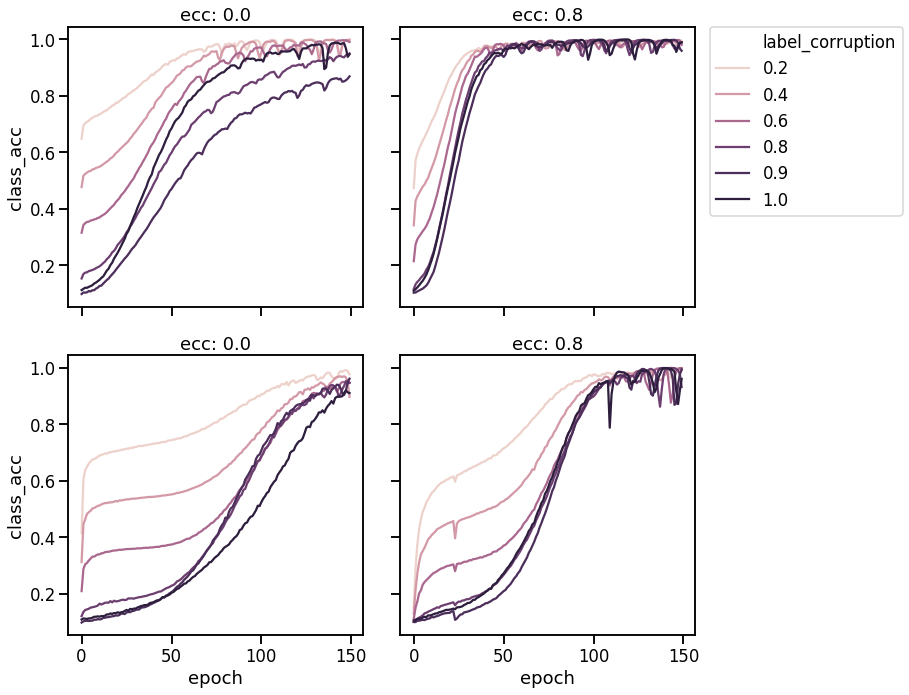

In [40]:
sns.set_context('talk')
fig = recon_ecc_grid(metric='class_acc',sharey='row',pop_out_legend=True,
                     subplot_kw={
#                          'yscale':'log',
                         'xscale':'linear',
#                          'ylim':(0.001,1500)
                     })

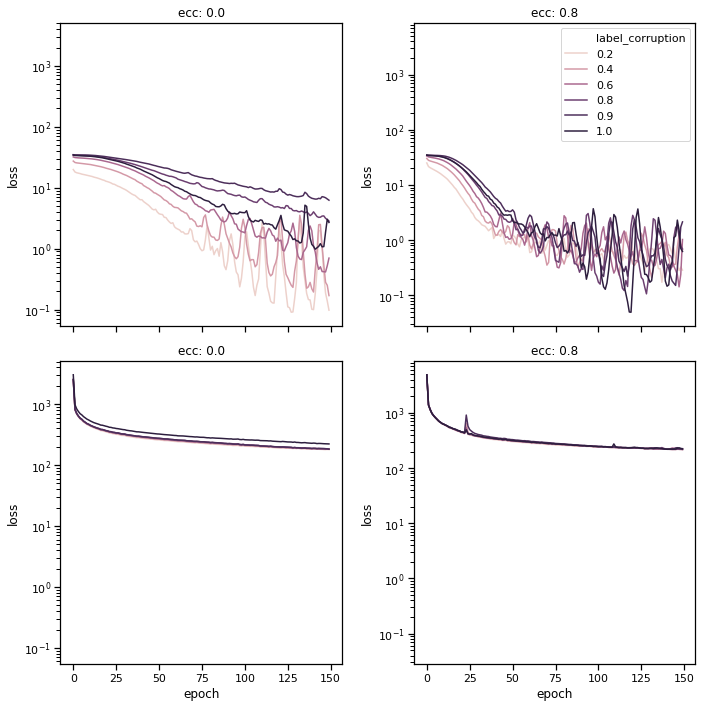

In [41]:
sns.set_context('notebook')
fig = recon_ecc_grid(metric='loss',sharey='col',
                    subplot_kw={
                         'yscale':'log',
                    })
fig.savefig('../figures/label_corruption_sweeps/train_loss.png',dpi=150)

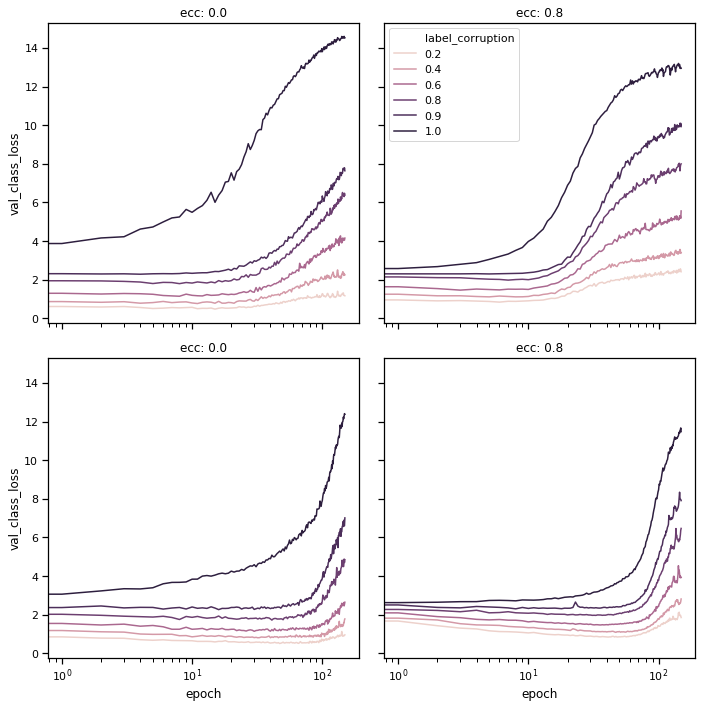

In [42]:
fig = recon_ecc_grid(metric='val_class_loss',sharey=True,
                    subplot_kw={
#                          'yscale':'log',
                         'xscale':'log',
                    })
# fig.savefig('../figures/label_corruption_sweeps/train_acc.png',dpi=150)

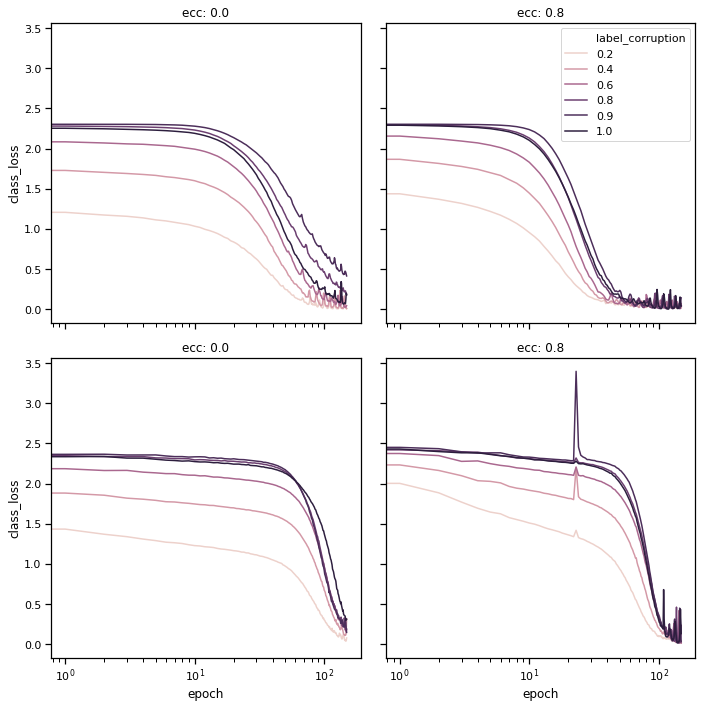

In [43]:
fig = recon_ecc_grid(metric='class_loss',sharey=True,
                    subplot_kw={
#                          'yscale':'log',
                         'xscale':'log',
                    })

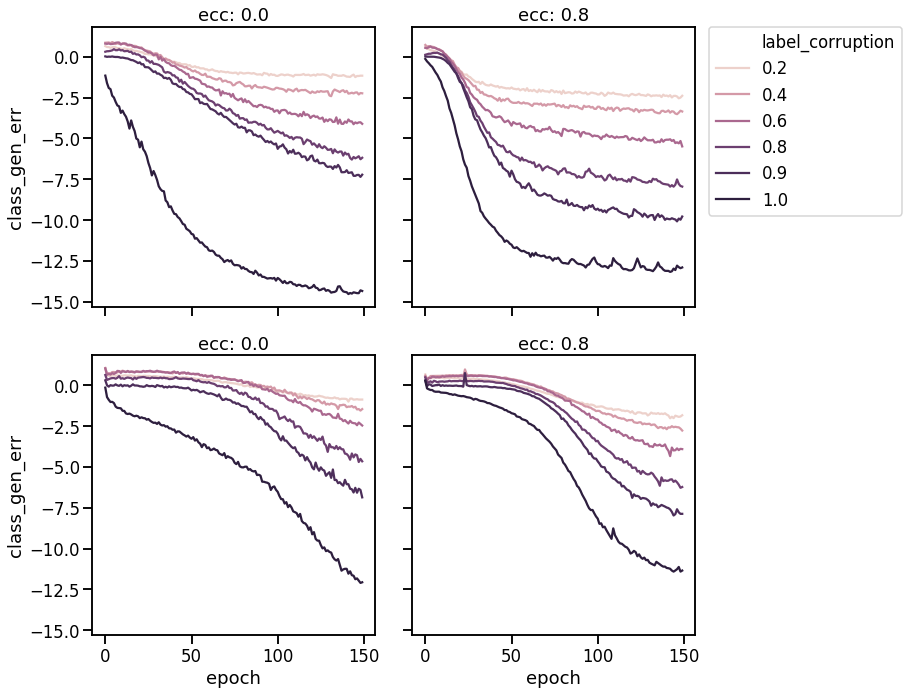

In [44]:
sns.set_context('talk')
fig = recon_ecc_grid(metric='class_gen_err',subplot_kw={'xscale':'linear'},pop_out_legend=True)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [45]:
leg = fig.axes[1].legend()

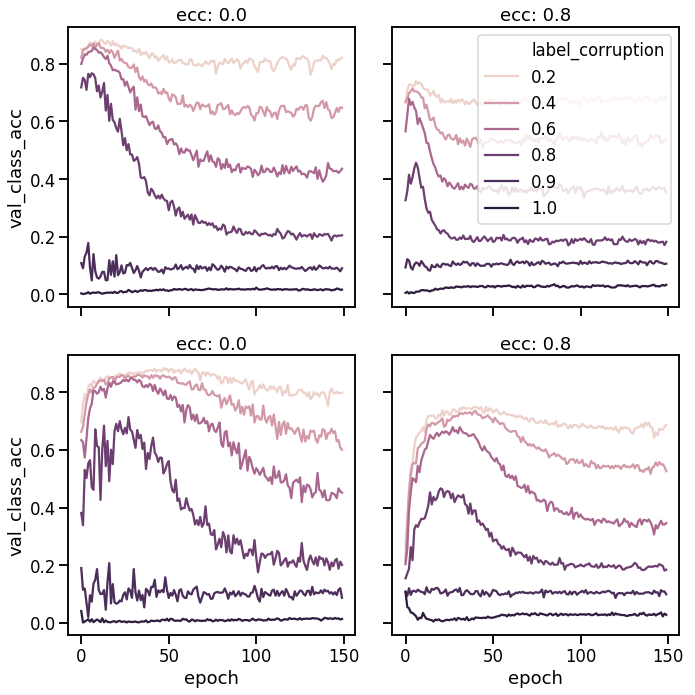

In [52]:
fig = recon_ecc_grid(metric='val_class_acc',
                     subplot_kw={
#                          'xscale':'log'
                     })

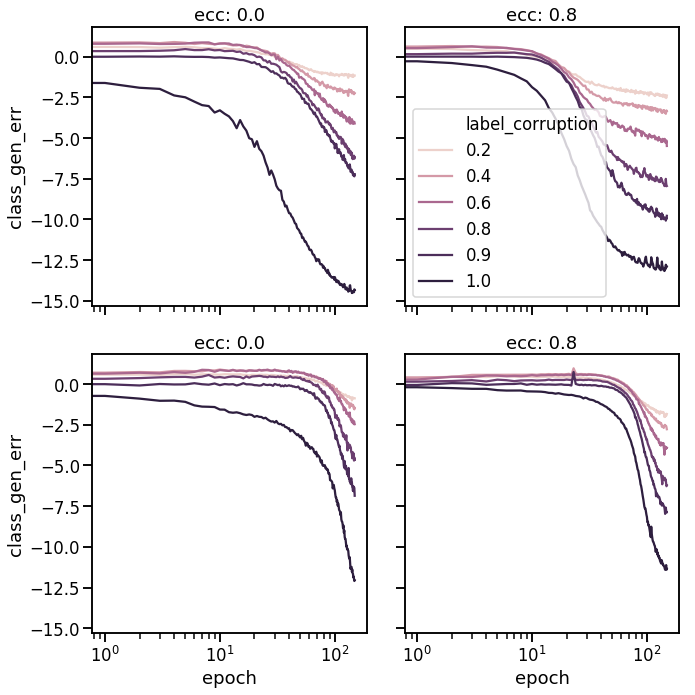

In [47]:
fig = recon_ecc_grid(metric='class_gen_err',subplot_kw={'xscale':'log'})

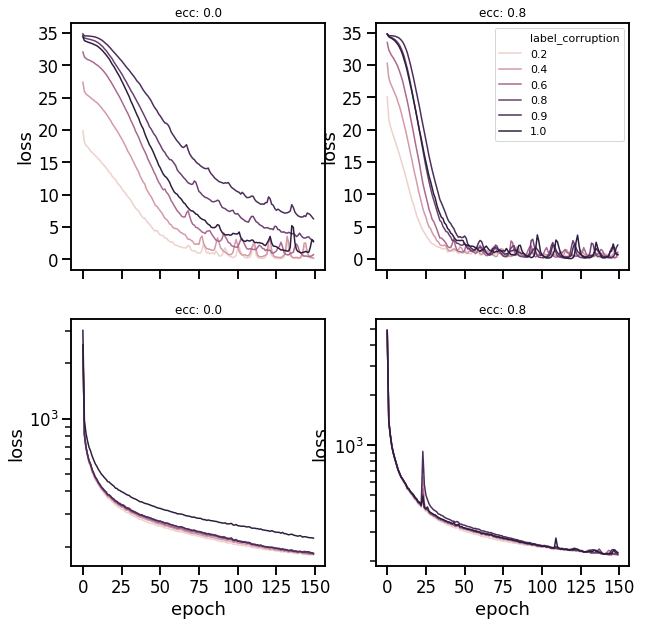

In [48]:
archs = ['no_recon','recon']
filts = [hist_df.architecture == a for a in archs]

fig,axs = plt.subplots(2,2,figsize=(10,10),
#                        sharey=True,
                       sharex=True,
                      )
sns.set_context('notebook')
for filt,i in zip(filts,np.arange(2)):
    if i == 0:
        leg = 'full'
    else:
        leg = None
    if len(hist_df[filt]) > 0:
        axs[1,i].set_yscale('log')
        sns.lineplot(x='epoch',y='loss',hue='label_corruption',data=hist_df[filt].query('ecc_max == 0.0'),ax=axs[i,0],legend=None)
        axs[i,0].set_title('ecc: 0.0')
        
        sns.lineplot(x='epoch',y='loss',hue='label_corruption',data=hist_df[filt].query('ecc_max == 0.8'),ax=axs[i,1],legend=leg)
        axs[i,1].set_title('ecc: 0.8')

In [49]:
def corruption_plot(x,y,hue,hue_order=None,style=None,data=None,legend=None,palette=None,ax=None):
    g = sns.lineplot(x=x,y=y,hue=hue,hue_order=hue_order,style=style,
                 data=data,legend=legend,palette=palette,ax=ax)
    if legend is not None:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return g

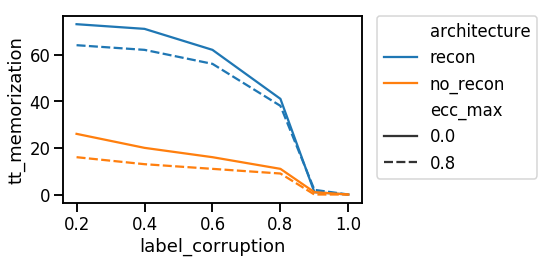

In [50]:
sns.set_context('talk')
fig,ax = plt.subplots(1,1,figsize=(8,4))
corruption_plot(x='label_corruption',y='tt_memorization',hue='architecture',style='ecc_max',data=perf_df,legend='full',ax=ax)
plt.tight_layout()
fig.savefig('../figures/label_corruption_sweeps/tt_memorization.png',dpi=150)

ValueError: Could not interpret input 'test_entropy'

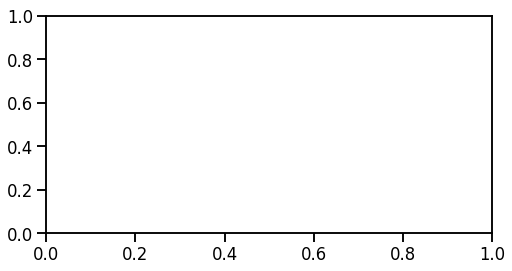

In [51]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
corruption_plot(x='label_corruption',y='test_entropy',hue='architecture',style='ecc_max',data=perf_df,legend='full',ax=ax)
plt.tight_layout()

In [ ]:
sns.set_context('talk')
corruption_plot(x='label_corruption',y='tt_memorization',hue='architecture',style='ecc_max',data=perf_df,legend='full',palette=sns.cubehelix_palette(2,start=5))
# fig,axs = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)


# axs[0].set_title('no_recon')

# g = sns.lineplot(x='label_corruption',y='tt_memorization',hue='ecc_max',hue_order=[0,0.8],
#                  data=perf_df.query('architecture == "recon"'),legend='full',ax=axs[1],palette=sns.cubehelix_palette(2,start=5))
# axs[1].set_title('recon')
# plt.ylim(0,1.1)
# plt.xlim(0,1.1)

In [ ]:
archs = ['no_recon','recon']
filts = [hist_df.architecture == a for a in archs]

fig,axs = plt.subplots(2,2,figsize=(10,10),
                       sharey=True,
                       sharex=True,
                      )
for filt,i in zip(filts,np.arange(2)):
    if i == 0:
        leg = 'full'
    else:
        leg = None
    if len(hist_df[filt]) > 0:
        sns.lineplot(x='epoch',y='val_class_loss',hue='label_corruption',hue_order=sorted(corruption_fractions[1:]),
                     data=hist_df[filt].query('ecc_max == 0.0'),ax=axs[i,0],legend=None)
        axs[i,0].set_title('ecc: 0.0',)
        
        sns.lineplot(x='epoch',y='val_class_loss',hue='label_corruption',hue_order=sorted(corruption_fractions[1:]),
                     data=hist_df[filt].query('ecc_max == 0.8'),ax=axs[i,1],legend=None)
        axs[i,1].set_title('ecc: 0.8')
        
fig.savefig('../figures/label_corruption_sweeps/val_class_loss.png',dpi=150)

In [ ]:
sns.set_context('talk')
fig,ax = plt.subplots(1,1,figsize=(8,4))
corruption_plot(x='label_corruption',y='test_loss_auc',hue='architecture',style='ecc_max',data=perf_df,legend='full')
plt.tight_layout()
fig.savefig('../figures/label_corruption_sweeps/test_loss_auc.png',dpi=150)

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(10,5),sharey=True,sharex=True)
g = sns.barplot(x='label_corruption',y='test_loss_auc',hue='architecture',hue_order=['recon','no_recon'],data=perf_df.query('ecc_max == 0.0'),ax=axs[0])
g = sns.barplot(x='label_corruption',y='test_loss_auc',hue='architecture',hue_order=['recon','no_recon'],data=perf_df.query('ecc_max == 0.8'),ax=axs[1])
# g.set(legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axs[0].set_xticklabels([0.2,0.4,0.6,0.8,0.9,1.0])
axs[1].set_xticklabels([0.2,0.4,0.6,0.8,0.9,1.0])
axs[1].set_ylabel('')
plt.tight_layout()
fig.savefig('../figures/label_corruption_sweeps/test_loss_auc_barplot.png',dpi=150)

In [ ]:

fig,axs = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
g = sns.lineplot(x='label_corruption',y='test_loss_auc',hue='ecc_max',hue_order=[0,0.8],
                 data=perf_df.query('architecture == "no_recon"'),legend='full',ax=axs[0],palette=sns.cubehelix_palette(2,start=5))
g = sns.lineplot(x='label_corruption',y='test_loss_auc',hue='ecc_max',hue_order=[0,0.8],
                 data=perf_df.query('architecture == "recon"'),legend='full',ax=axs[1],palette=sns.cubehelix_palette(2,start=5))

# plt.ylim(0,1.1)
# plt.xlim(0,1.1)

In [ ]:
# sns.set_context('talk')

# fig,axs = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
# g = sns.lineplot(x='label_corruption',y='test_loss_auc',hue='architecture',hue_order=['no_recon','recon'], data=perf_df.query('ecc_max == "0.0"'),legend='full',ax=axs[0])
# g = sns.lineplot(x='label_corruption',y='test_loss_auc',hue='architecture',hue_order=['no_recon','recon'],data=perf_df.query('ecc_max == "0.8"'),legend='full',ax=axs[1])

# # plt.ylim(0,1.1)
# # plt.xlim(0,1.1)

In [ ]:
sns.cubehelix_palette(6)

In [ ]:
archs = ['no_recon','recon']
filts = [hist_df.architecture == a for a in archs]

fig,axs = plt.subplots(2,2,figsize=(10,10),
                       sharey=True,
                       sharex=True,
                       subplot_kw={'ylim':(0,1)}
                      )
for filt,i in zip(filts,np.arange(2)):
    if i == 1:
        leg = 'full'
    else:
        leg = None
    if len(hist_df[filt]) > 0:
        sns.lineplot(x='epoch',y='val_class_acc',hue='label_corruption',data=hist_df[filt].query('ecc_max == 0.0'),ax=axs[i,0],legend=None)
#         axs[i,0].set_title('no_recon')
        
        sns.lineplot(x='epoch',y='val_class_acc',hue='label_corruption',data=hist_df[filt].query('ecc_max == 0.8'),ax=axs[i,1],legend=None)
#         axs[i,1].set_title('recon')
        for c,chance in zip(sns.cubehelix_palette(6,reverse=True,start=1),[0.1,0.2,0.4,0.6,0.8]): 
            axs[i,0].axhline(y=chance,ls='dashed',color=c,xmin=0.25)
            axs[i,1].axhline(y=chance,ls='dashed',color=c,xmin=0.25)
            
fig.savefig('../figures/label_corruption_sweeps/val_class_acc.png',dpi=150)